# Load datasets and pacakges

In [ ]:
!nvidia-smi

Wed Sep 13 14:06:10 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.105.17   Driver Version: 525.105.17   CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    25W / 300W |      0MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [1]:
%%capture
!pip3 install anthropic openai tiktoken bertopic umap hdbscan

In [2]:
# Import packages
import pandas as pd
import numpy as np
from numpy import random
import matplotlib.pyplot as plt
import os
import re
import time
from tqdm import tqdm
from scipy import stats
from scipy.stats import ttest_ind
from google.colab import drive
from google.colab import userdata
from typing import Tuple
from Utils.utils_topic_modeling import (
    plot_grid_search_result,
    document_topic_matrix,
    get_combined_topic_info,
    topic_distribution,
    show_topic_keyword,
    generate_target_audience,
    classification_by_audience,
    calculate_weighted_topic,
    similarity_check,
    plot_change,
    perform_t_test,
    visualization,
    visualization_dot_plot,
)

# sklearn
from sklearn.decomposition import LatentDirichletAllocation
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from pprint import pprint

# LLM API
import openai
import tiktoken
import anthropic

In [3]:
# API KEY
GOOGLE_API_KEY = userdata.get('GOOGLE_API_KEY')
OPENAI_API_KEY = userdata.get('OPENAI_API_KEY')
CLAUDE_API_KEY = userdata.get('CLAUDE_API_KEY')
HUGGINGFACE_API_KEY = userdata.get('HUGGINGFACE_API_KEY')

# Set seed
SEED = random.randint(100)
np.random.seed(SEED)

# Setup work directory
drive.mount('/content/drive')
os.chdir('/content/drive/MyDrive/Dissertation')
os.listdir() # overview the files

Mounted at /content/drive


['stopwords_zh-tw.txt',
 'Manifestos_RawData',
 'Final_Data',
 'Graph',
 '碩士論文研究計畫書.docx',
 'NMF_Result',
 'Result',
 'Manifesto_Dataset.csv',
 'Embedding_OPENAI_SENTENCE.csv',
 'Manifesto_Dataset_Origin.csv',
 '__pycache__',
 'Embedding_OPENAI_SENTENCE_Origin.csv',
 'Manifesto_Dataset_Origin.gsheet',
 'Dataset_Regression.csv']

# LDA Model

In [6]:
df = pd.read_csv('Manifesto_Dataset_Origin.csv')

## Vectorizer

In [ ]:
data = df.TOKEN.values.tolist()
print(data[:1])

['建請 政府 落實 農民 提升 農民 生活 品質 \n二 建全 農產 運銷 制度 保障 農民 權益 全工 退休 失業 制度 及早 實施 全民 \n四 建請 有效 落實 老人 殘障 兒童 更生 保護 弱勢 團體 福利 法律 。\n五 建請 加速 保障村 改建 合理化 人性化 取銷 階級 分配 差距 \n六 建請 及早 陽光法案 杜絶 貪污 利益 輪送 以下 空白']


In [ ]:
# remove tokens that appeared more than 99% and less than 0.5% of the manifestos
vectorizer = CountVectorizer(analyzer='word',
                             max_df=0.99,
                             min_df=int(0.005 * len(data)))
data_vectorized = vectorizer.fit_transform(data)
print(data_vectorized.shape)

(3444, 3176)


In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=79,           # Number of topics
                                      max_iter=12,               # Max learning iterations
                                      learning_method='batch',
                                      batch_size=256,
                                      learning_decay=0.7,
                                      random_state=SEED,         # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      verbose=3
                                     )

In [ ]:
lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

iteration: 1 of max_iter: 12
iteration: 2 of max_iter: 12
iteration: 3 of max_iter: 12
iteration: 4 of max_iter: 12
iteration: 5 of max_iter: 12
iteration: 6 of max_iter: 12
iteration: 7 of max_iter: 12
iteration: 8 of max_iter: 12
iteration: 9 of max_iter: 12
iteration: 10 of max_iter: 12
iteration: 11 of max_iter: 12
iteration: 12 of max_iter: 12
LatentDirichletAllocation(batch_size=256, max_iter=12, n_components=79,
                          random_state=21, verbose=3)


In [ ]:
# Log Likelihood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -2933531.6341272285
Perplexity:  1133.3221025202238
{'batch_size': 256,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 12,
 'mean_change_tol': 0.001,
 'n_components': 79,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 21,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 3}


## Hyperparameter tuning

In [ ]:
# Define Search Param
n_topics = list(range(89, 95, 1)) # 89-94
search_params = {'n_components': n_topics, 'learning_decay': [.3], 'batch_size': [128]}

# Init the Model
lda = LatentDirichletAllocation(max_iter=10,               # Max learning iterations
                                learning_method='batch',
                                random_state=SEED,         # Random state
                                evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                )


model = GridSearchCV(lda, param_grid=search_params, cv=3, verbose=3)
model.fit(data_vectorized)

Fitting 3 folds for each of 6 candidates, totalling 18 fits


/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


[CV 1/3] END batch_size=128, learning_decay=0.3, n_components=89;, score=-1202477.416 total time=  29.3s
[CV 2/3] END batch_size=128, learning_decay=0.3, n_components=89;, score=-1151066.626 total time=  23.0s
[CV 3/3] END batch_size=128, learning_decay=0.3, n_components=89;, score=-1348362.005 total time=  28.9s
[CV 1/3] END batch_size=128, learning_decay=0.3, n_components=90;, score=-1198148.589 total time=  32.9s
[CV 2/3] END batch_size=128, learning_decay=0.3, n_components=90;, score=-1150088.787 total time=  26.2s
[CV 3/3] END batch_size=128, learning_decay=0.3, n_components=90;, score=-1351824.525 total time=  27.4s
[CV 1/3] END batch_size=128, learning_decay=0.3, n_components=91;, score=-1203862.388 total time=  26.7s
[CV 2/3] END batch_size=128, learning_decay=0.3, n_components=91;, score=-1154956.070 total time=  30.5s
[CV 3/3] END batch_size=128, learning_decay=0.3, n_components=91;, score=-1354891.467 total time=  25.9s
[CV 1/3] END batch_size=128, learning_decay=0.3, n_comp

GridSearchCV(cv=3,
             estimator=LatentDirichletAllocation(n_jobs=-1, random_state=58),
             param_grid={'batch_size': [128], 'learning_decay': [0.3],
                         'n_components': [89, 90, 91, 92, 93, 94]},
             verbose=3)

In [ ]:
# Best Model
best_lda_model = model.best_estimator_
print("Best Model's Params: ", model.best_params_)
print("Best Log Likelihood Score: ", model.best_score_)
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'batch_size': 128, 'learning_decay': 0.3, 'n_components': 90}
Best Log Likelihood Score:  -1233353.9671231054
Model Perplexity:  1214.183932983693


## Visualization of Model Performance

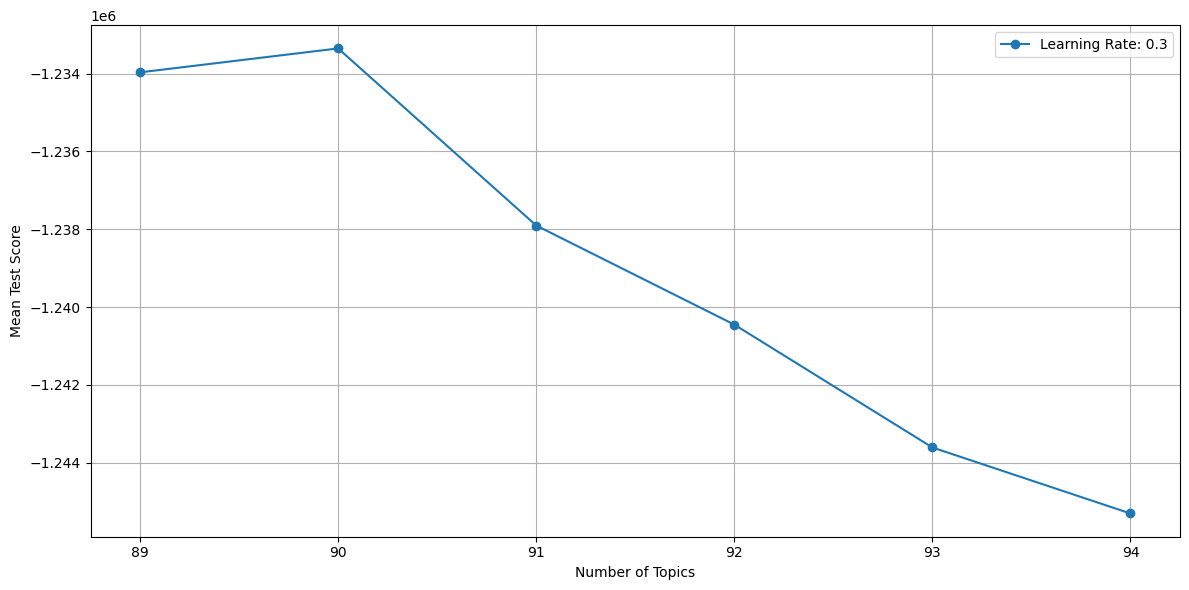

In [ ]:
plot_grid_search_result(model, save=True)

## Re-run LDA model

In [ ]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_components=90,           # Number of topics
                                      max_iter=12,               # Max learning iterations
                                      learning_method='batch',
                                      batch_size=128,
                                      learning_decay=0.3,
                                      random_state=SEED,         # Random state
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      verbose=3
                                     )

In [ ]:
lda_model.fit_transform(data_vectorized)
print(lda_model)  # Model attributes

iteration: 1 of max_iter: 12
iteration: 2 of max_iter: 12
iteration: 3 of max_iter: 12
iteration: 4 of max_iter: 12
iteration: 5 of max_iter: 12
iteration: 6 of max_iter: 12
iteration: 7 of max_iter: 12
iteration: 8 of max_iter: 12
iteration: 9 of max_iter: 12
iteration: 10 of max_iter: 12
iteration: 11 of max_iter: 12
iteration: 12 of max_iter: 12
LatentDirichletAllocation(learning_decay=0.3, max_iter=12, n_components=90,
                          random_state=88, verbose=3)


In [ ]:
print("Log Likelihood: ", lda_model.score(data_vectorized))
print("Perplexity: ", lda_model.perplexity(data_vectorized))
pprint(lda_model.get_params())

Log Likelihood:  -2946220.42491789
Perplexity:  1168.3279206090742
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.3,
 'learning_method': 'batch',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 12,
 'mean_change_tol': 0.001,
 'n_components': 90,
 'n_jobs': None,
 'perp_tol': 0.1,
 'random_state': 88,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 3}


# Result Overview

In [ ]:
df_document_topic, topicnames = document_topic_matrix(df_=df, lda_model=lda_model, data=data_vectorized)
df_document_topic

,0,1,2,3,4,5,6,7,8,9,...,82,83,84,85,86,87,88,89,Dominant_topic,ID
0,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,29,0b534f0b-eebc-43f2-8e8e-ea7a35bc3ced
1,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,68,9b0f7e5c-1ba1-4fa1-b2a5-046ea47837b3
2,0.0,0.0,0.09,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.06,0.0,0.0,0.0,0.00,0.0,0.00,0.0,29,fd551f5d-e03c-45d3-97eb-d041f7ea0c6e
3,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,29,5abf6f62-0025-453d-b743-e722a3fc026f
4,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.22,0.0,0.0,0.0,0.00,0.0,0.00,0.0,29,636ebbfc-f4b4-490d-9f86-177001d8ca40
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3439,0.0,0.0,0.00,0.0,0.15,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,67,443e0ce2-4ff7-4697-9269-8cb7eca48e81
3440,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.07,0.0,0.00,0.0,66,eddcd040-c72b-41c7-a1d4-c3ef520f4c30
3441,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.16,0.0,0.0,0.0,0.00,0.0,0.00,0.0,54,1b5f8360-86f4-41f7-a224-135ed5552eff
3442,0.0,0.0,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,...,0.00,0.0,0.0,0.0,0.00,0.0,0.00,0.0,26,692dd397-88d6-42f8-88e3-208bc92ee797


In [ ]:
topic_info = get_combined_topic_info(vectorizer, lda_model, df_document_topic, df)
topic_info

,Topic,Keywords,Representative_Docs
0,0,"[改革, 正義, 推動, 政府, 兩岸, 落實, 轉型, 捍衛, 和平, 經濟]",[捍衛 國家 主權 維護 臺海 和平 \n二 釐清 憲政 體制 終結 憲政 亂象 \n三 改...
1,1,"[新竹, 新竹市, 立法, 市民, 爭取, 香山, 竹科, 保障, 兩岸, 科學園區]",[臺灣人 生存權 人權 憲法 明訂 保障 臺灣人 貧窮 戰爭 平等 平等 倡議 合作主義 成...
2,2,"[服務, 法案, 社會, 福利, 民生, 支持, 推動, 爭取, 生活, 經濟]",[參選 理念 有情 有義 邱創良 處事 最佳 寫照 堅持 親民 服務 不畏 強權 邱創良 服...
3,3,"[臺東, 樹林, 土城, 三峽, 板橋, 鶯歌, 政府, 中央, 問題, 興建]",[捍衛 中華民國 堅持 反對 臺獨 全民 團結 泛藍 立委 過半 有效 監督 政府 維護 民...
4,4,"[推動, 安全, 照顧, 環境, 強化, 就業, 食品, 照護, 落實, 產業]",[英派 改革 適應 維新 在地 專業 深耕 基隆 。\n 蔡英文 總統 候選人 林右昌 市長...
...,...,...,...
85,85,"[保障, 爭取, 聯合, 婦女, 勢力, 推動, 參政, 力量, 輔導, 完成]",[臺十三線 三義 外環道 動工 銅鑼 外環道 完成 \n二 義售 山線 鐵路 觀光 列車 起...
86,86,"[臺灣, 大陸, 和平, 國家, 經濟, 兩岸, 學生, 恢復, 家庭, 生活]",[爭取 和平 紅利 造福 臺灣 \n一 一國兩制 尊重 原則 大陸 展開 對等 尊嚴 政治 ...
87,87,"[立委, 減半, 國會, 席次, 政府, 失業, 推動, 經濟, 選區, 單一]",[鄭重 聲明 汐止 地匾 立委 候選人 自許 選區 鄉鎮 選民 支持 整治 汐止 水患 職志...
88,88,"[臺中, 中部, 臺中市, 臺中港, 推動, 機場, 發展, 升格, 直航, 政府]",[美鳳 高票 當選 臺北市 議員 松山 信義區 處理 宗教 掃黑 宋七力 事件 新竹市 文化...


### Topic Distribution

In [ ]:
df_topic_distribution = topic_distribution(df_document_topic)
df_topic_distribution

,Topic,Document Count
0,8,348
1,29,333
2,35,259
3,54,232
4,82,166
...,...,...
85,89,9
86,88,8
87,85,6
88,30,3


### Top N Words

In [ ]:
df_topic_keywords = show_topic_keyword(vectorizer, lda_model, n_keywords=15)
df_topic_keywords

,Topic 0,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,...,Topic 22,Topic 23,Topic 24,Topic 25,Topic 26,Topic 27,Topic 28,Topic 29,Topic 30,Topic 31
Word 0,爭取,台中,直航,板橋,建設,免費,金門,爭取,台灣,推動,...,價格,推動,台灣,應該,中華民國,政府,加強,房舍,制定,政策
Word 1,教育,方面,前瞻性,新莊,政策,政見,鄉親,推動,政治,台灣,...,罷免,發展,國家,能夠,品質,津貼,空間,安置,保障,開放
Word 2,加強,中部,國内,樹林,福利,所得,兩岸,發展,生活,中國,...,清查,教育,立委,當選,問政,興建,台灣,殘障,制度,預算
Word 3,改善,台中市,四號,停車場,教育,學生,離島,建設,政黨,社會,...,員工,特色,主張,立法委員,基隆,農地,建立,保障,發展,政府
Word 4,環境,優化,駐外,土城,環境,網路,地區,觀光,服務,提升,...,大選,資源,政治,支持,立場,開發,國際,勞工,加強,教育
Word 5,加速,機場,東西向,三峽,發展,窮人,中央,地方,社會,改革,...,腐敗,檢討,選舉,長輩,監督,屏東,設置,社會,基本法,取消
Word 6,福利,台中港,綠線,新北市,安全,一律,爭取,加速,正義,積極,...,意見,政策,經濟,選舉,負責,地區,爭取,照顧,安全,全面
Word 7,落實,大台中,租屋,鶯歌,改善,工作,大陸,督促,和平,平等,...,免稅,生態,民主,立即,促進,問題,協助,提升,行政,公務員
Word 8,交通,臺中,首都,停車,交通,上網,醫療,中央,力量,老人,...,萬大,社區,國會,現在,淸廉,解決,生活,教育,教育,社會
Word 9,教師,太平,工業區,公園,台東,法制,觀光,捷運,百姓,安全,...,處罰,保障,世界,大同,追求,老人,勞工,專業,平等,刪除


# Classification

## Target Audience Generation

In [ ]:
generation_config = {
    "candidate_count": 1,
    "max_output_tokens": 256,
    "temperature": 0.95,
    "top_p": 0.95,
    "top_k": 40,
    "repetition_penalty": 1.1
    }

In [ ]:
topic_info = generate_target_audience(topic_info, 'GPT', config=generation_config)

Generating target audiences: 100%|██████████| 90/90 [08:20<00:00,  5.56s/it]


In [ ]:
topic_info = generate_target_audience(topic_info, 'Claude', config=generation_config)

Generating target audiences: 100%|██████████| 90/90 [17:11<00:00, 11.46s/it]


## Post Process

In [ ]:
# We use 廖達琪's standard of classification
audience_list = ["全民", "軍公教", "台商", "老人", "婦女", "原住民", "族群(閩南、客家族群、眷村)", "外籍人士",
                "學生", "中壯年", "青年", "兒童", "榮民", "勞工", "藝文人士", "工商企業", "醫療人員", "病人", "選手",
                "公益團體(社福團體)", "專業人士", "社工員", "自由行旅客", "特殊技能人士", "弱勢(含性工作者、更生人、卡奴、腳踏車騎士)",
                "僑民", "殘障(身心障礙)", "失業", "低收入戶", "中間選民", "投資者", "父母家長親子", "單親家庭",
                "選任公務人員(議員、里長)", "農漁民", "網民", "地區居民"]


In [ ]:
topic_info = classification_by_audience(topic_info)
topic_info.head(3)

Similarity of GPT vs. Claude: 0.744


,Topic,Keywords,Representative_Docs,Target_Audience_GPT,GPT_Explanation,Target_Audience_Claude,Claude_Explanation,PORK_GPT,PORK_Claude,PORK_AI
0,0,"[改革, 正義, 推動, 政府, 兩岸, 落實, 轉型, 捍衛, 和平, 經濟]",[捍衛 國家 主權 維護 臺海 和平 \n二 釐清 憲政 體制 終結 憲政 亂象 \n三 改...,"[弱勢(含性工作者、更生人、卡奴、腳踏車騎士), 全民]",Target audience,"[弱勢(含性工作者、更生人、卡奴、腳踏車騎士), 勞工, 中低收入戶, 全民]",Target audience,0,0,0
1,1,"[新竹, 新竹市, 立法, 市民, 爭取, 香山, 竹科, 保障, 兩岸, 科學園區]",[臺灣人 生存權 人權 憲法 明訂 保障 臺灣人 貧窮 戰爭 平等 平等 倡議 合作主義 成...,[地區居民(勞工; 老人; 婦女; 學生; 勞工; 農漁民; 中低收入戶; 父母家長親子; ...,Target audience,[地區居民(勞工; 工商企業; 中低收入戶; 老人; 青年; 父母家長親子; 學生; 弱勢(...,Target audience,1,0,-1
2,2,"[服務, 法案, 社會, 福利, 民生, 支持, 推動, 爭取, 生活, 經濟]",[參選 理念 有情 有義 邱創良 處事 最佳 寫照 堅持 親民 服務 不畏 強權 邱創良 服...,"[全民, 地區居民]",Target audience,"[勞工, 老人, 弱勢(含性工作者、更生人、卡奴、腳踏車騎士), 中低收入戶, 父母家長親子...",Target audience,0,0,0


## Save Results

In [ ]:
versions = 3
MODEL = 'LDA'
df_document_topic.to_csv(f'Result/Result_V2/{MODEL}_Large/Result_v{versions}/document_topic_v{versions}.csv', encoding='utf-8-sig', index=False)
topic_info.to_csv(f'Result/Result_V2/{MODEL}_Large/Result_v{versions}/topic_info_v{versions}.csv', encoding='utf-8-sig', index=False)

# Result Visulization

In [7]:
## LDA
# Result of version 1 classification (20240504)
# Result of version 2 classification (20240505)
# Result of version 3 classification (20240506)

## BERTopic
# Result of version 1 classification (20240507)
# Result of version 2 classification (20240507)
# Result of version 3 classification (20240507)
topic_info = {}
df_document_topic = {}
versions = 3
MODEL = 'LDA'
FILE_PATH = f'{MODEL}_Large'

for n in range(1, versions+1):
    version = f'v{n}' # v1
    topic_info[version] = pd.read_csv(f'Result/Result_V2/{FILE_PATH}/Result_{version}/topic_info_{version}.csv')
    df_document_topic[version] = pd.read_csv(f'Result/Result_V2/{FILE_PATH}/Result_{version}/document_topic_{version}.csv')
    pork = topic_info[version][topic_info[version]['PORK'] == 1]['Topic'].tolist()
    df = calculate_weighted_topic(df, df_document_topic[version], topic_info[version])
    print(similarity_check(topic_info[version]))

Similarity of GPT vs. Claude: 0.689
Similarity of GPT vs. human: 0.967
Similarity of Claude vs. human: 0.722
(87, 65)
Similarity of GPT vs. Claude: 0.733
Similarity of GPT vs. human: 0.889
Similarity of Claude vs. human: 0.844
(80, 76)
Similarity of GPT vs. Claude: 0.767
Similarity of GPT vs. human: 0.956
Similarity of Claude vs. human: 0.811
(86, 73)


In [8]:
df_serious = df[df['SERIOUS_CANDIDATE'] == 1]
cols = ['PORK_v1', 'PORK_v2', 'PORK_v3']
df['PORK_LDA_Manifesto'] = df[cols].mean(axis=1)

In [ ]:
df.info()

## T test

In [ ]:
df['LNAME'] = df['LNAME'].astype(str)
df['LNAME'] = df['LNAME'].apply(lambda x: x.split('_')[0])
filtered_df = df[df['TH'].isin([6, 7])]
candidates_in_both = filtered_df.groupby('LNAME').filter(lambda x: x['TH'].nunique() == 2)
candidates_in_both.groupby('TH').size()

TH
6    123
7    123
dtype: int64

mean: 0.25, std: 0.211
mean: 0.406, std: 0.236


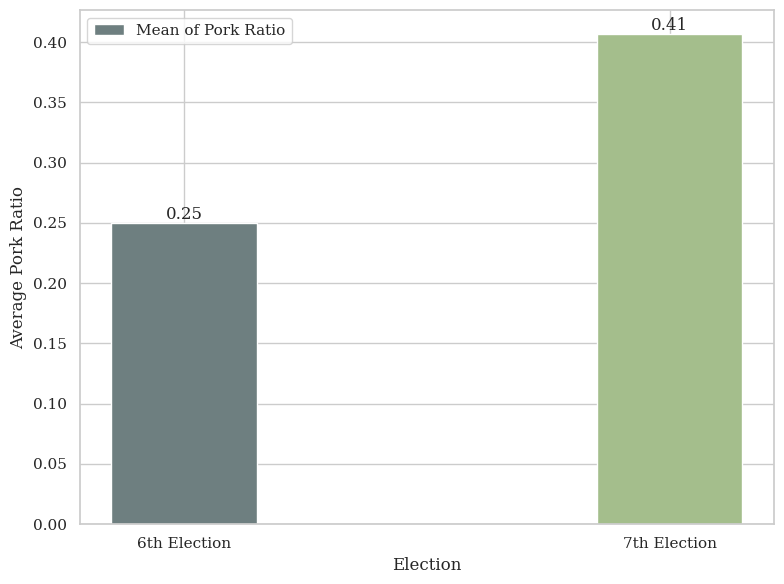

In [ ]:
plot_change(candidates_in_both, cols, model=MODEL, save=True)

In [ ]:
t_stat, p_value = perform_t_test(df=candidates_in_both,
                                 columns=cols,
                                 candidate='連任候選人'
                                 )

TtestResult(statistic=-5.475479926038514, pvalue=5.471396759243238e-08, df=241.00108127758017)
ConfidenceInterval(low=-inf, high=-0.10910006170951395)

第六屆平均: 0.25, 第六屆標準差: 0.21 
第七屆平均: 0.406, 第七屆標準差: 0.235 

連任候選人間存在顯著差異。


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious, 
                                 columns=cols, 
                                 candidate='認真型候選人'
                                 )

變異數有顯著差異
TtestResult(statistic=-6.671341153371146, pvalue=4.388535974575949e-11, df=387.3695417807113)
ConfidenceInterval(low=-inf, high=-0.10691357066411451)

第六屆平均: 0.237, 第六屆標準差: 0.209 
第七屆平均: 0.379, 第七屆標準差: 0.252 

認真型候選人間存在顯著差異。


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious.query('PARTY_CODE == 1'), 
                                 columns=cols, 
                                 candidate='國民黨候選人'
                                 )

print(f"國民黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] == 1])}")
print(f"第六屆國民黨提名人數: {len(df_serious.query('PARTY_CODE == 1 and TH == 6'))}")
print(f"第七屆國民黨提名人數: {len(df_serious.query('PARTY_CODE == 1 and TH == 7'))}")

TtestResult(statistic=-6.0418122095196525, pvalue=6.744180479433582e-09, df=137.51148367678454)
ConfidenceInterval(low=-inf, high=-0.15610486707271914)

第六屆平均: 0.23, 第六屆標準差: 0.203 
第七屆平均: 0.445, 第七屆標準差: 0.215 

國民黨候選人間存在顯著差異。
國民黨提名人數: 824
第六屆國民黨提名人數: 70
第七屆國民黨提名人數: 70


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious.query('PARTY_CODE == 2'), 
                                 columns=cols, 
                                 candidate='民進黨候選人'
                                 )

print(f"民進黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] == 2])}")
print(f"民進黨提名人數: {len(df_serious.query('PARTY_CODE == 2 and TH == 6'))}")
print(f"民進黨提名人數: {len(df_serious.query('PARTY_CODE == 2 and TH == 7'))}")

TtestResult(statistic=-4.744906148444648, pvalue=2.53754272771136e-06, df=140.46064628487585)
ConfidenceInterval(low=-inf, high=-0.11102515155725193)

第六屆平均: 0.255, 第六屆標準差: 0.214 
第七屆平均: 0.426, 第七屆標準差: 0.23 

民進黨候選人間存在顯著差異。
民進黨提名人數: 710
民進黨提名人數: 90
民進黨提名人數: 69


In [ ]:
t_stat, p_value = perform_t_test(df=df_serious.query('PARTY_CODE > 2'), 
                                 columns=cols, 
                                 candidate='小黨候選人'
                                 )

print(f"小黨提名人數: {len(df_serious[df_serious['PARTY_CODE'] > 2])}")
print(f"小黨提名人數: {len(df_serious.query('PARTY_CODE > 2 and TH < 7'))}")
print(f"小黨提名人數: {len(df_serious.query('PARTY_CODE > 2 and TH >= 7'))}")

變異數有顯著差異
TtestResult(statistic=-0.9224910398295166, pvalue=0.3583415966753658, df=107.32934331603093)
ConfidenceInterval(low=-0.1075407550238361, high=0.03923641920500161)

第六屆平均: 0.228, 第六屆標準差: 0.209 
第七屆平均: 0.262, 第七屆標準差: 0.267 

小黨候選人間不存在顯著差異。
小黨提名人數: 1322
小黨提名人數: 695
小黨提名人數: 627


## Visualization

In [ ]:
plt.rcdefaults()
SAVE = True

Number of candidates: 2856


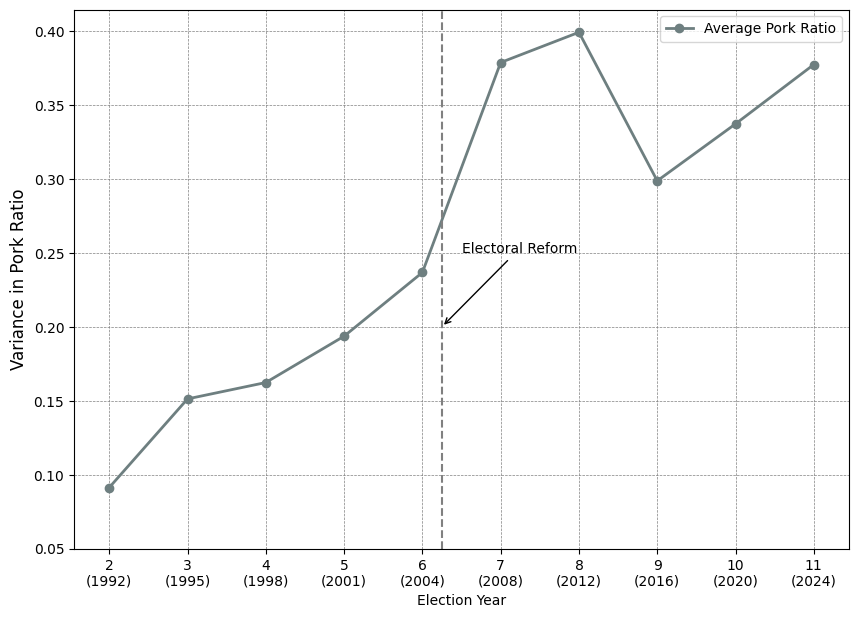

In [67]:
%matplotlib inline
visualization(df=df_serious,
              model=MODEL,
              y_axis=0.2,
              party='Serious',
              columns=cols,
              reform_year=2005,
              highlight=False,
              save=SAVE,
              avg=True) # 2856

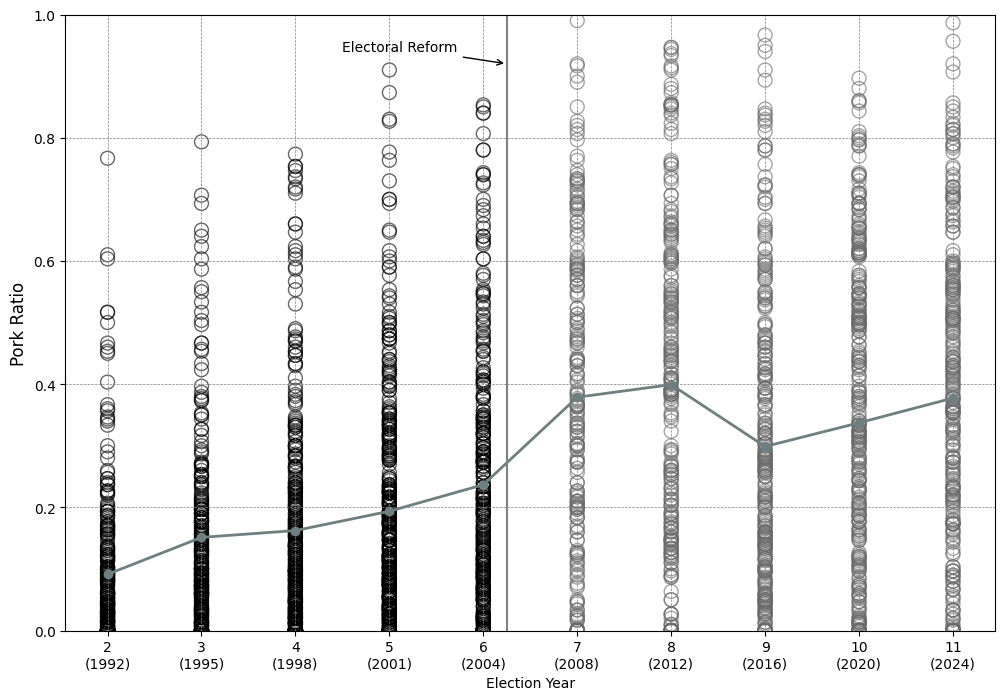

In [97]:
%matplotlib inline
visualization_dot_plot(df=df_serious,
                        model=MODEL,
                        party='Serious',
                        columns=cols,
                        save=SAVE
                       ) # 2856

Number of candidates: 824
   TH      PORK
0   2  0.111246
1   3  0.172912
2   4  0.217290
3   5  0.229148
4   6  0.230429
5   7  0.445476
6   8  0.536048
7   9  0.437269
8  10  0.463568
9  11  0.415000


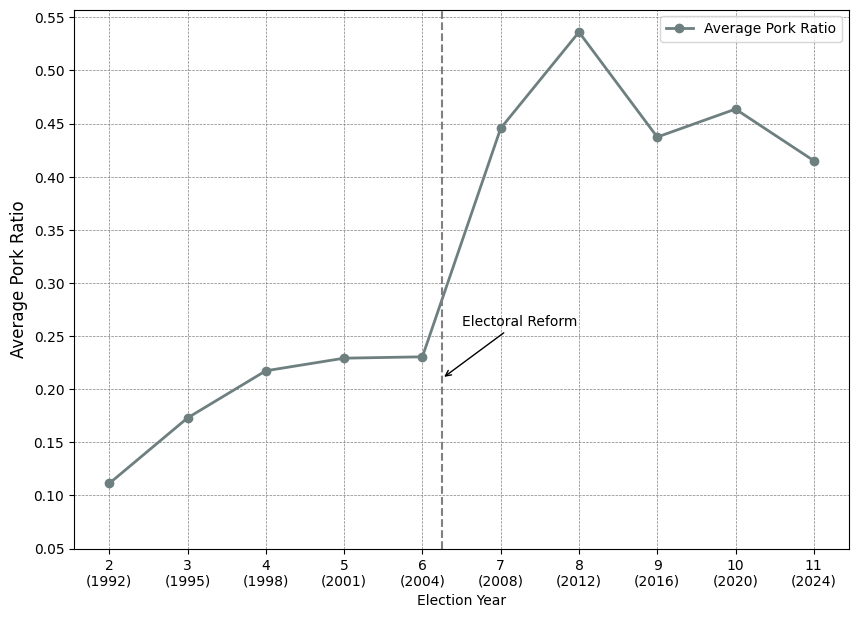

In [ ]:
%matplotlib inline
visualization(df=df_serious.query('PARTY_CODE == 1'),
              model=MODEL,
              y_axis=0.21,
              party='KMT',
              columns=cols,
              reform_year=2005,
              highlight=False,
              save=SAVE,
              avg=True) # 824

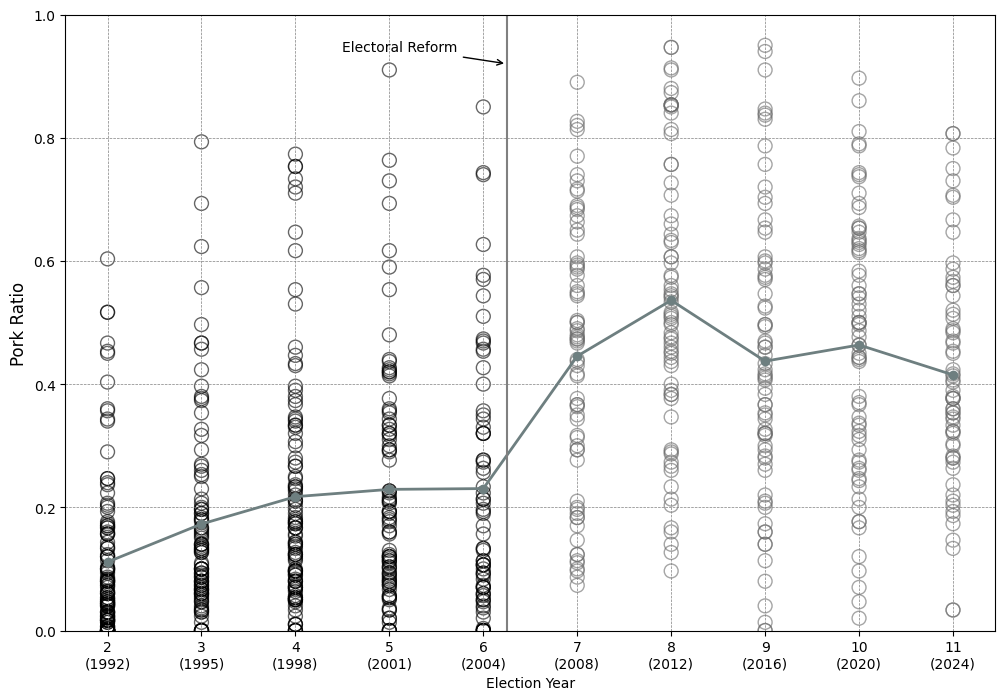

In [98]:
%matplotlib inline
visualization_dot_plot(df=df_serious.query('PARTY_CODE == 1'),
                        model=MODEL,
                        party='KMT',
                        columns=cols,
                        save=SAVE
                       )

Number of candidates: 710
   TH      PORK
0   2  0.038218
1   3  0.113188
2   4  0.126414
3   5  0.187257
4   6  0.255407
5   7  0.425942
6   8  0.414810
7   9  0.430000
8  10  0.512687
9  11  0.551449


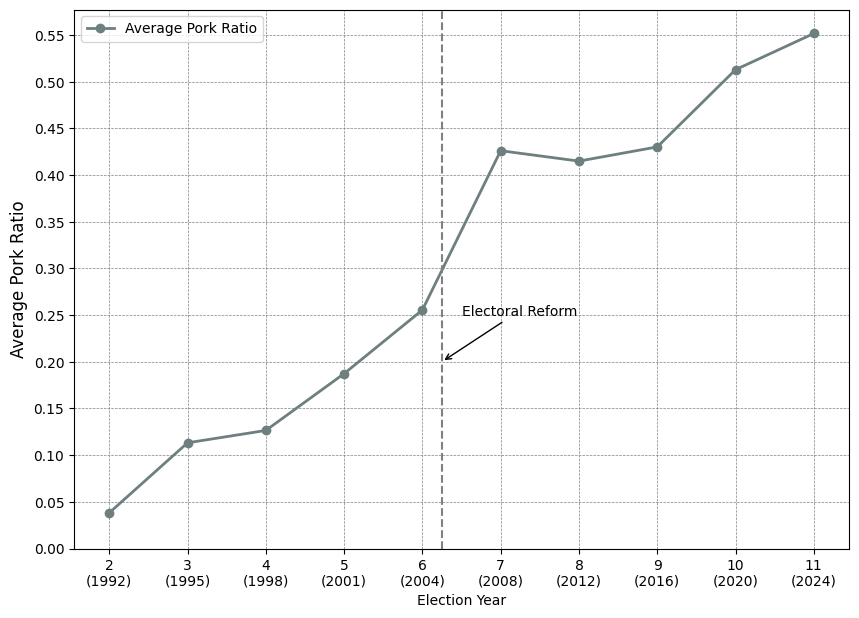

In [ ]:
%matplotlib inline
visualization(df=df_serious.query('PARTY_CODE == 2'),
              model=MODEL,
              y_axis=0.2,
              party='DPP',
              columns=cols,
              reform_year=2005,
              highlight=False,
              save=SAVE,
              avg=True) # 710

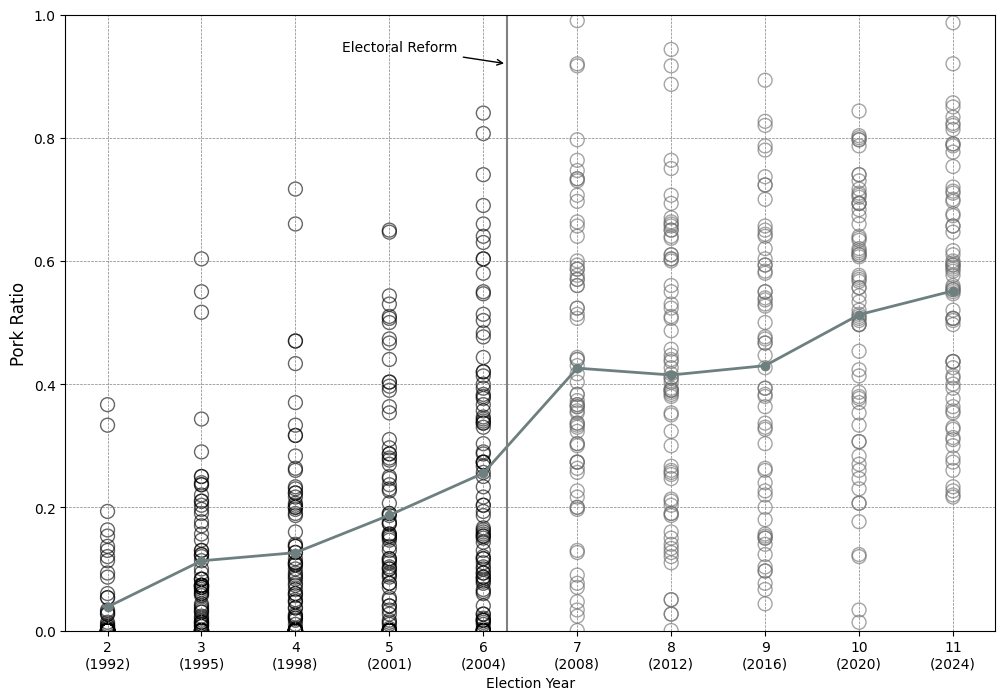

In [99]:
%matplotlib inline
visualization_dot_plot(df=df_serious.query('PARTY_CODE == 2'),
                        model=MODEL,
                        party='DPP',
                        columns=cols,
                        save=SAVE
                       )

Number of candidates: 1322
   TH      PORK
0   2  0.099125
1   3  0.157240
2   4  0.142975
3   5  0.180345
4   6  0.228005
5   7  0.262157
6   8  0.290272
7   9  0.180464
8  10  0.218800
9  11  0.270543


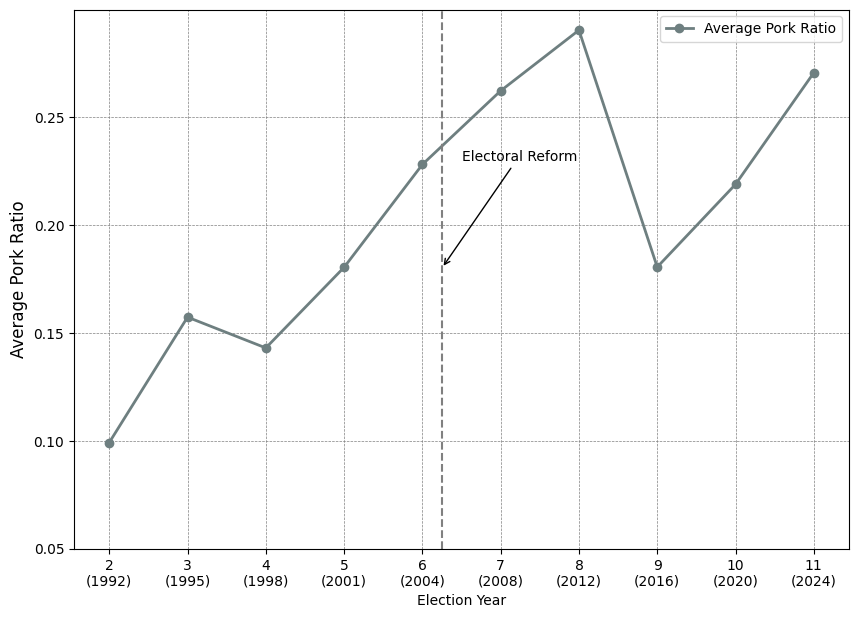

In [ ]:
%matplotlib inline
visualization(df=df_serious.query('PARTY_CODE > 2'),
              model=MODEL,
              y_axis=0.18,
              party='Non-KMT&DPP',
              columns=cols,
              reform_year=2005,
              highlight=False,
              save=SAVE,
              avg=True) # 1322

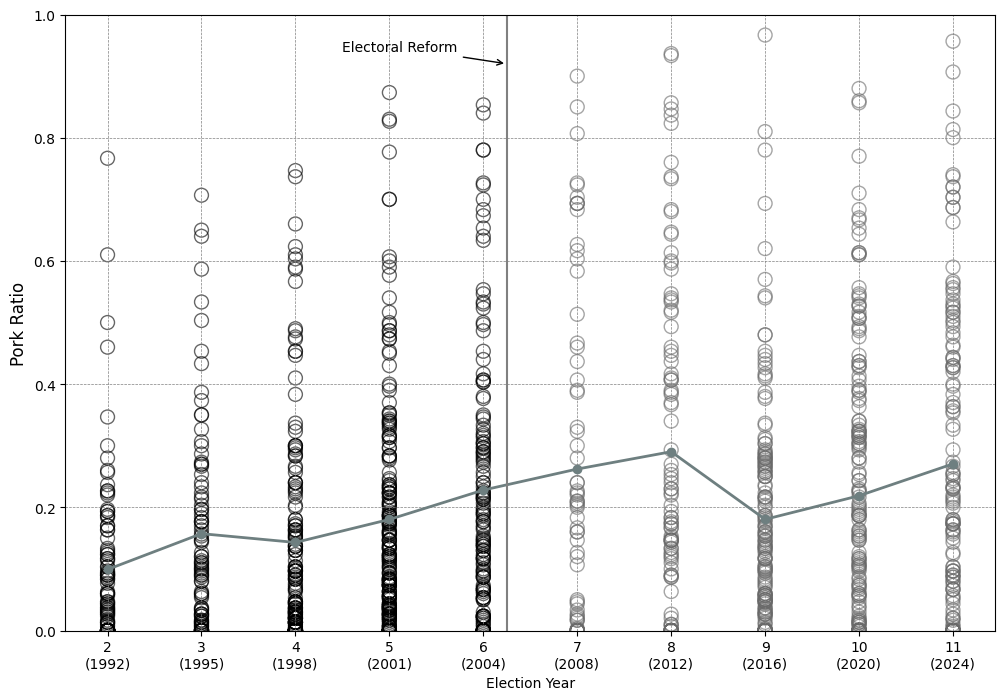

In [100]:
%matplotlib inline
visualization_dot_plot(df=df_serious.query('PARTY_CODE > 2'),
                        model=MODEL,
                        party='Non-KMT&DPP',
                        columns=cols,
                        save=SAVE
                       )